In [1]:
# Python Imports
import sys, os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-Image
from skimage.io import imread

# TensorFlow Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.experimental import AdamW

# Loading the dataset

In [2]:
cifar100 = tf.keras.datasets.cifar100

# Splitting Data into Training and Testing and Scaling

In [3]:
# Creating data splits (training and testing)
(x_train, y_train), (x_test, y_test) = cifar100.load_data() 
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1 # Scaling data to from 0 to 255 to -1 to 1
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape) # Takes the shape of (# Samples, Pixels, Pixels, color space)
print("x_test.shape:", x_test.shape) # Takes the shape of (# Samples, Pixels, Pixels, color space)
print("y_train.shape:", y_train.shape) # Takes the shape of (# Samples)
print("y_test.shape:", y_test.shape) # Takes the shape of (# Samples)

x_train.shape: (50000, 32, 32, 3)
x_test.shape: (10000, 32, 32, 3)
y_train.shape: (50000,)
y_test.shape: (10000,)


In [4]:
N, H, W, C = x_train.shape
D = H * W
# x_train = x_train.reshape(-1, D)
# x_test = x_test.reshape(-1, D)

In [5]:
print("N:", N, "\nH:", H, "\nW:", W, "\nC:", C, "\nD:", D )
print("x_train.shape:", x_train.shape) # Takes the shape of (# Samples, Pixels x Pixels)
print("x_test.shape:", x_test.shape) # Takes the shape of (# Samples, Pixels x Pixels)

N: 50000 
H: 32 
W: 32 
C: 3 
D: 1024
x_train.shape: (50000, 32, 32, 3)
x_test.shape: (10000, 32, 32, 3)


# Setting Variable to store number of classes

In [6]:
K = len(set(y_train))
print("Number of classes:", K)

Number of classes: 100


# Setting Latent Space Dimensions

In [7]:
latent_dim = 100

# Shuffling Data

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(y_train)).batch(64)
print(len(y_train))

50000


# Class to Build Generator

In [9]:
# Model below is a class based on a modified VGG Model
# Initial working model

# def build_generator(latent_dim):
#     i = Input(shape=(latent_dim))
#     x = (Dense(256*8*8, use_bias=False, activation=LeakyReLU(alpha=0.2)))(i)
#     x = BatchNormalization(momentum=0.8)(x)
#     x = Reshape((8, 8, 256))(x)
#     x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation=LeakyReLU(alpha=0.2))(x)
#     x = BatchNormalization()(x)
#     x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation=LeakyReLU(alpha=0.2))(x)
#     x = BatchNormalization()(x)
#     # x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation=LeakyReLU(alpha=0.2))(x)
#     x = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)
#     print(x.shape)
#     model = Model(i, x) 
#     return model

In [10]:
def build_generator(latent_dim):
    i = Input(shape=(latent_dim))
    x = (Dense(256*8*8, use_bias=False, activation=LeakyReLU(alpha=0.2)))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Reshape((8, 8, 256))(x)
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization()(x)
    # x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)
    print(x.shape)
    model = Model(i, x) 
    return model

In [11]:
# generator = build_generator(latent_dim)

In [12]:
generator = tf.keras.models.load_model('./Models/Simple_generator2.keras')

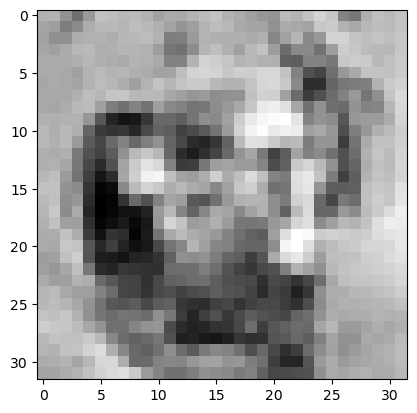

In [13]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Class to Build Discriminator

In [14]:
def build_discriminator():
    i = Input(shape=x_train[0].shape)
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(i)
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)
    x = Flatten()(x)
    # x = Dropout(0.4)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(i, x)
    return model

# Compiling Both Models for Training

In [15]:
discriminator = tf.keras.models.load_model('./Models/Simple_discriminator2.keras')

In [16]:
# discriminator = build_discriminator()
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

In [17]:
z = Input(shape=(latent_dim,))

In [18]:
img = generator(z)

In [19]:
discriminator.trainable = False
fake_pred = discriminator(img)
fake_pred

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'model_1')>

In [20]:
combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [21]:
batch_size = 64
epochs = 30000
sample_period = 200 # every 'sample_period' steps generate and save some data

In [22]:
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

In [23]:
d_losses = []
g_losses = []

In [24]:
if not os.path.exists('gan_images_2'):
  os.makedirs('gan_images_2')

In [25]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescale images [0, 1]
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx, :, :,])
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images_2/%d.png" % epoch)
    plt.close()

In [26]:
for epoch in range(epochs):
    ###########################
    ### Train discriminator ###
    ###########################

    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise, verbose=0)

    # Train the discriminator
    # Both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)




    #######################
    ### Train generator ###
    #######################
  
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
  
    # do it again!
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
  
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % sample_period == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
    if epoch % sample_period == 0:
        sample_images(epoch)

epoch: 1/30000, d_loss: 0.64, d_acc: 0.59, g_loss: 0.97
1/1 [==============================] - 0s 86ms/step
epoch: 201/30000, d_loss: 2.71, d_acc: 0.29, g_loss: 0.01
1/1 [==============================] - 0s 10ms/step
epoch: 401/30000, d_loss: 3.21, d_acc: 0.24, g_loss: 0.00
1/1 [==============================] - 0s 11ms/step


KeyboardInterrupt: 

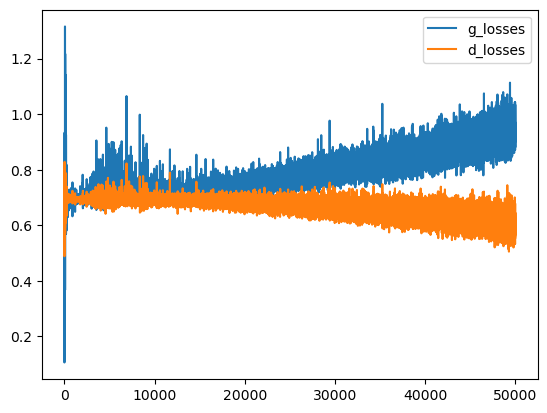

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

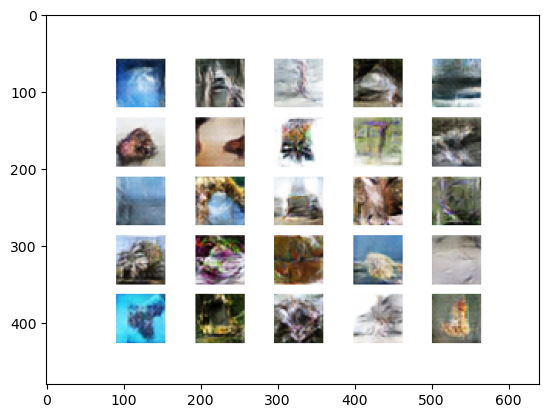

In [ ]:
a = imread('gan_images/29800.png')
plt.imshow(a)

In [ ]:
from numpy.random import randn
def generator_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
def create_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1+i)
        plt.axis('off')
        plt.imshow(examples[i, :, :])
        plt.show()

In [ ]:
discriminator.save('./Models/Simple_discriminator2.hd5')

In [ ]:
generator.save('./Models/Simple_generator2.hd5')